In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import scipy.ndimage as nd
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader

In [ ]:

def get_cifar10_dataloaders(val_percentage=0.1, batch_size=20):

  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

  dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train

  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

  data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)

  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)

  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)

  return data_loader_train, data_loader_val, data_loader_test


_ = get_cifar10_dataloaders()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
classes[1]

'car'

Files already downloaded and verified
Files already downloaded and verified


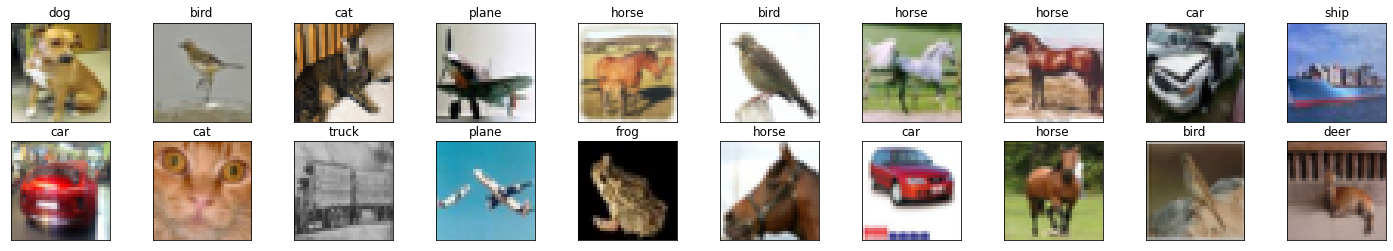

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image / 2 + 0.5     # unnormalize
  image = image.transpose(1, 2, 0)
  # print(image.shape)
  # image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  # image = image.clip(0, 1)
  return image

a,_,_=get_cifar10_dataloaders( batch_size=20)
dataiter = iter(a)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
#completed upto here

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)



cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
data_loader_train, data_loader_val, data_loader_test=get_cifar10_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.200
[2,  2000] loss: 1.729
[3,  2000] loss: 1.487
[4,  2000] loss: 1.359
[5,  2000] loss: 1.270
[6,  2000] loss: 1.195
[7,  2000] loss: 1.136
[8,  2000] loss: 1.082
[9,  2000] loss: 1.035
[10,  2000] loss: 0.993
Finished Training


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
predictions = []
y_true=[]
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(list(predicted.view(-1).cpu().numpy()))
        y_true.extend(list(labels.view(-1).cpu().numpy()))

# y_true = dataset_test.labels[data_loader_test.indices]
print("f1 score on 1000 images after 10 epochs: ",f1_score(predictions,y_true, average='micro'))
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

f1 score on 1000 images after 10 epochs:  0.6201
Accuracy of the network on the 10000 test images: 62 %
